# Functional Connectivity Second Level Analysis in Volume
Load group connectivity maps and run statistical analyses in volume space
1. Load list of saved nifti maps for each subject
1. Test for statistical significance of correlation maps (Is the connectivity strength significantly different from zero?)
2. Test for difference between maps of different ROIs
3. Save t-test map
4. Save significant clusters as separate nii.gz images
5. Load saved clusters, extract correlation values from group map and save as dataframe
6. calculate correlations between connectivity values and reading scores

In [1]:
# Compare and analyze seed-based connectivity maps
# import
from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn import image
from nilearn import masking
import numpy as np
import pandas as pd
import glob
import os
import nilearn
#import scipy as scp
from nilearn import signal
from scipy import stats
import nibabel as nib
from os.path import exists
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from nilearn.regions import connected_regions

In [2]:
# Define paths:
projectdir = '/scratch/groups/jyeatman/HBN_FC/'
space = 'volume' # volume or surface analysis
datadir = projectdir + space + '/statMaps/'
analysesdir = projectdir + space + '/analyses/'
inputdir = projectdir + 'input/'

# Load fsaverage
fsaverage = datasets.fetch_surf_fsaverage('fsaverage',data_dir = '/home/groups/jyeatman/software')

# Load LH surface to get its size
white_left = surface.load_surf_data(fsaverage['white_left'])
# Load RH surface to get its size
white_right = surface.load_surf_data(fsaverage['white_right'])

# Paths to surface ROIs from Emily:
roidir =  '/home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/'
roi_names = ['MPM_lh_IOS.label','lh_pOTS_chars.label','lh_mOTS_chars.label']
# the IOS ROI is a character selective ROI from Rosenke 2021, looks like OWFA

if space == 'volume':
# ROIs from volume analysis (transformed to the surface)
    roi_names = ['VWFA1','VWFA2']


# Parameters for current run:
task = 'rest' #'rest' / 'movie'
saveFigures = False
hemi = 'left'

# Threshold the statistical maps
if task == 'rest':
    thresh=3.4
    clust_thresh=50
    t_thresh=4
    t_clust_thresh=200
elif task == 'movie':
    thresh=3.4
    clust_thresh=50


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/nilearn/surface/surface.py:671: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([arr.data for arr in gifti_img.darrays]).T.squeeze()


In [3]:
# Load subject fmri data
# Load subject list
subject_file = projectdir+ 'subs_preprocessed_restingstate_movieDM_meanFD05_SNR15_FD05_90_WIAT_FilteredAfterScrubbing_0.5_0.2.csv'
if task == 'rest':
    subject_file = projectdir+ 'subs_preprocessed_onlyrest_meanFD05_SNR15_FD05_90_WIAT.csv'
elif task == 'movie':
    subject_file = projectdir+ 'subs_preprocessed_onlymovie_meanFD05_SNR15_FD05_90_WIAT.csv'
sub_list = pd.read_csv(subject_file)
subs = sub_list['participant_id']

In [4]:
files_roi1 = sorted(glob.glob(datadir + 'sub-*'+task + '*' + roi_names[0] + '*zMap.nii.gz'), key=os.path.basename) # this gets the full path
files_roi2 = sorted(glob.glob(datadir + 'sub-*'+task + '*' + roi_names[1] + '*zMap.nii.gz'), key=os.path.basename) # this gets the full path
# we have to sort, otherwise lists have different orders

In [5]:
print('Found ' + str(len(files_roi1)) + ' files for ROI1')
print('Found ' + str(len(files_roi2)) + ' files for ROI2')
testid = 57
print(files_roi1[testid])
print(files_roi2[testid])
print(subs[testid])

Found 231 files for ROI1
Found 231 files for ROI2
/scratch/groups/jyeatman/HBN_FC/volume/statMaps/sub-NDARFM619GTV_task-rest_VWFA1_zMap.nii.gz
/scratch/groups/jyeatman/HBN_FC/volume/statMaps/sub-NDARFM619GTV_task-rest_VWFA2_zMap.nii.gz
sub-NDARFM619GTV


In [15]:
sub_list[sub_list['WIAT_Word_Raw'].isna()]

,Unnamed: 0,X.1,X,X.x,participant_id,preproc,existsRun1,existsRun2,existsMovieDM,existsMovieTP,...,rec_id,run_id,raw_neighbor_corr_pass,t1_neighbor_corr_pass,mean_fd_pass,t1_dice_distance_pass,raw_num_bad_slices_pass,qc_pass,WIAT_Word_Raw,WIAT_Word_Stnd
80,81,550,550,550,sub-NDARHW270BD0,1,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,106,703,703,703,sub-NDARKP893TWU,1,1,1,0,0,...,NaN,NaN,True,True,True,True,True,1.0,NaN,NaN
127,128,863,863,863,sub-NDARMV319CAT,1,1,1,0,0,...,NaN,NaN,True,True,True,True,True,1.0,NaN,NaN
153,154,1047,1047,1047,sub-NDARRL426AD5,1,1,1,0,0,...,NaN,NaN,False,False,True,True,False,0.0,NaN,NaN
211,212,1436,1436,1436,sub-NDARYD195BDH,1,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217,218,1463,1463,1463,sub-NDARYL124VM6,1,1,1,0,0,...,NaN,NaN,True,True,True,True,True,1.0,NaN,NaN
219,220,1467,1467,1467,sub-NDARYM063XB8,1,1,1,0,0,...,NaN,NaN,True,True,True,True,True,1.0,NaN,NaN


### Test significance of correlations with single seed ROIs

<AxesSubplot:label='conditions', ylabel='scan number'>

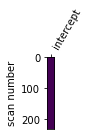

In [6]:
# create design matrix for single ROI
single_roi_design_matrix = pd.DataFrame([1] * len(files_roi1),columns=['intercept']) 
fig, ax = plt.subplots(figsize=(1, 2), nrows=1, ncols=1)
plotting.plot_design_matrix(single_roi_design_matrix,ax=ax)

In [7]:
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel(smoothing_fwhm=None) # original value was 8.0

/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


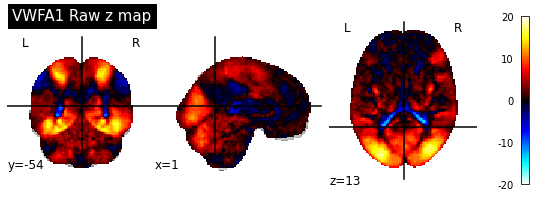

In [8]:
# Fit first ROI
roi1_second_level = second_level_model.fit(files_roi1,design_matrix=single_roi_design_matrix)
roi1_zmap = roi1_second_level.compute_contrast(output_type='z_score')
display = plotting.plot_stat_map(roi1_zmap, title='VWFA1 Raw z map')

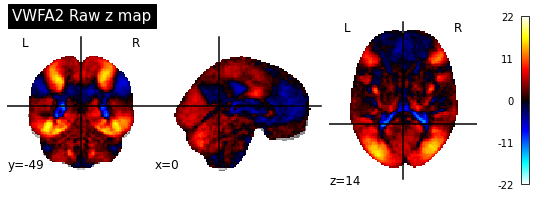

In [9]:
# Fit second ROI
roi2_second_level = second_level_model.fit(files_roi2,design_matrix=single_roi_design_matrix)
roi2_zmap = roi2_second_level.compute_contrast(output_type='z_score')
display = plotting.plot_stat_map(roi2_zmap, title='VWFA2 Raw z map')

20.16371923032984
21.66055970838299


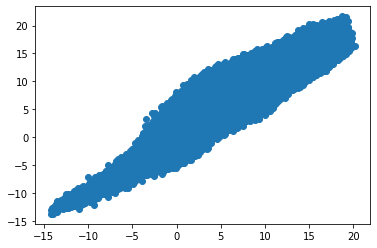

In [10]:
# Test to make sure we get different maps
roi1_vals = roi1_zmap.get_fdata().flatten()
roi2_vals = roi2_zmap.get_fdata().flatten()
plt.scatter(roi1_vals,roi2_vals)
print(np.max(roi1_vals))
print(np.max(roi2_vals))

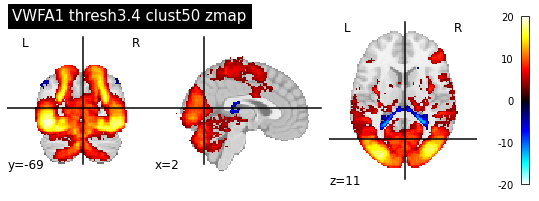

In [12]:
roi1_thresh_map = image.threshold_img(roi1_zmap,threshold=thresh,cluster_threshold=clust_thresh,two_sided=True)
display = plotting.plot_stat_map(roi1_thresh_map, title='VWFA1 thresh'+ str(thresh) + ' clust' + str(clust_thresh) + ' zmap')

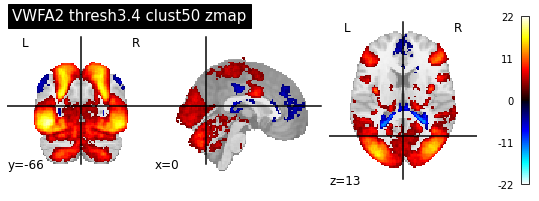

In [13]:
roi2_thresh_map = image.threshold_img(roi2_zmap,threshold=thresh,cluster_threshold=clust_thresh,two_sided=True)
display = plotting.plot_stat_map(roi2_thresh_map, title='VWFA2 thresh'+ str(thresh) + ' clust' + str(clust_thresh) + ' zmap')

### Compare correlation patterns between the two seed ROIs:
#### Where in the brain are the correlations significantly different from each other? 
#### Run a paired samples t-test

In [14]:
# create another design matrix for paired sample t-test
subject_effect = pd.DataFrame(np.vstack((np.eye(len(files_roi1)), np.eye(len(files_roi2)))))
roi_effect = pd.DataFrame([1]*len(files_roi1) + [-1]*len(files_roi2))

subjects = [f'S{i:02d}' for i in range(len(subs))]

ttest_design_matrix= pd.DataFrame(np.hstack((roi_effect, subject_effect)),
    columns=['seed']+subjects)

<AxesSubplot:label='conditions', ylabel='scan number'>

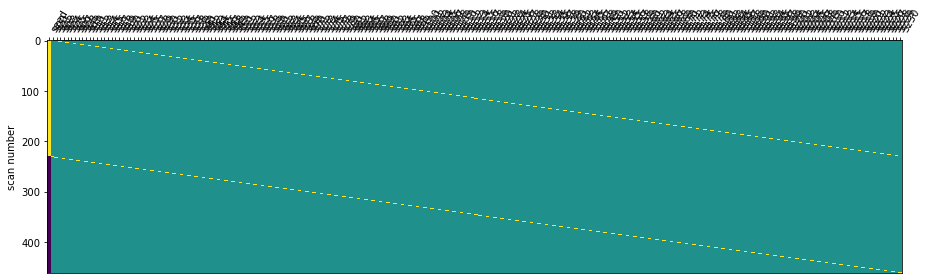

In [15]:
fig, ax = plt.subplots(figsize=(13, 4), nrows=1, ncols=1)
plotting.plot_design_matrix(ttest_design_matrix,rescale=False,ax=ax)
#ttest_design_matrix['S13'].head(20)

In [16]:
# run the t-test
ttest_second_level = second_level_model.fit(files_roi1 + files_roi2,design_matrix=ttest_design_matrix)

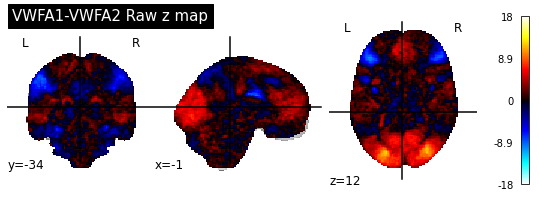

In [17]:
ttest_zmap = ttest_second_level.compute_contrast('seed',output_type='z_score')
display = plotting.plot_stat_map(ttest_zmap, title='VWFA1-VWFA2 Raw z map')

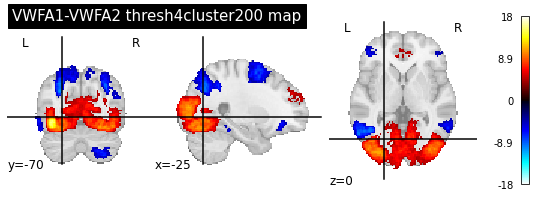

In [18]:
#plot and threshold map
# Threshold the map
# We define different thresholds for the t-test map (not the same ones used for single seeds)
#thresh=4
#clust_thresh=200 # clust_thres is in voxels
ttest_zmap_thresh = image.threshold_img(ttest_zmap,threshold=t_thresh,cluster_threshold=t_clust_thresh,two_sided=True)
display = plotting.plot_stat_map(ttest_zmap_thresh, cut_coords=(-25,-70,0),title='VWFA1-VWFA2 thresh' + str(t_thresh) + 'cluster' + str(t_clust_thresh)+' map')

(<Figure size 288x324 with 5 Axes>,
 [<Axes3DSubplot:>,
  <Axes3DSubplot:>,
  <Axes3DSubplot:>,
  <Axes3DSubplot:>,
  <AxesSubplot:>])

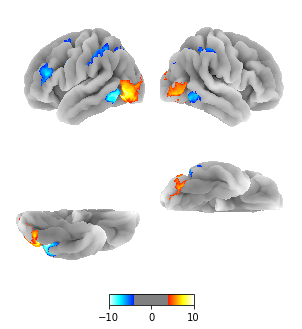

In [56]:
# plot on surface
plotting.plot_img_on_surf(stat_map=ttest_zmap_thresh, surf_mesh='fsaverage',vmax=10,threshold=thresh,
                            views=['lateral','ventral'])

In [ ]:
# Save all maps as nifti as well
roi1_zmap.to_filename(analysesdir + task +'_N_' + str(len(subs)) + '_' +'VWFA1_zMap.nii.gz')
roi2_zmap.to_filename(analysesdir + task +'_N_' + str(len(subs)) + '_' +'VWFA2_zMap.nii.gz')
ttest_zmap.to_filename(analysesdir + task +'_N_' + str(len(subs)) + '_' +'ttest.nii.gz')

# Save all thresholded maps
thresh_filename = task +'_N_' + str(len(subs)) + '_T'+ str(thresh)+ '_CT'+str(clust_thresh)+'_VWFA1_zMap.nii.gz'
roi1_thresh_map.to_filename(analysesdir + thresh_filename)
roi2_thresh_map.to_filename(analysesdir + str.replace(thresh_filename,'VWFA1','VWFA2'))
ttest_thresh_zmap.to_filename(analysesdir + task +'_N_' + str(len(subs)) + '_T'+ str(t_thresh)+ '_CT'+str(t_clust_thresh)+'_ttest.nii.gz')

## Create and save pretty figures

In [7]:
# Load these maps directly from file without running the whole notebook
roi1_zmap = image.load_img(analysesdir + task +'_N_' + str(len(subs)) + '_' +'VWFA1_zMap.nii.gz')
roi2_zmap = image.load_img(analysesdir + task +'_N_' + str(len(subs)) + '_' +'VWFA2_zMap.nii.gz')
ttest_zmap = image.load_img(analysesdir + task +'_N_' + str(len(subs)) + '_' +'ttest.nii.gz')

# Change here thresholds to load different niftis
# thresh=
# clust_thresh=
# t_thresh=
# t_clust_thresh

thresh_filename = task +'_N_' + str(len(subs)) + '_T'+ str(thresh)+ '_CT'+str(clust_thresh)+'_VWFA1_zMap.nii.gz'
roi1_thresh_map = image.load_img(analysesdir + thresh_filename)
roi2_thresh_map = image.load_img(analysesdir + str.replace(thresh_filename,'VWFA1','VWFA2'))
ttest_thresh_zmap = image.load_img(analysesdir + task +'_N_' + str(len(subs)) + '_T'+ str(t_thresh)+ '_CT'+str(t_clust_thresh)+'_ttest.nii.gz')


In [57]:
# vol2surf statistical maps for plotting
roi1_thresh_surf_lh = surface.vol_to_surf(roi1_thresh_map,surf_mesh=fsaverage['white_left'])
roi2_thresh_surf_lh = surface.vol_to_surf(roi2_thresh_map,surf_mesh=fsaverage['white_left'])
ttest_thresh_surf_lh = surface.vol_to_surf(ttest_zmap_thresh,surf_mesh=fsaverage['white_left'])
# same for right hemi
roi1_thresh_surf_rh = surface.vol_to_surf(roi1_thresh_map,surf_mesh=fsaverage['white_right'])
roi2_thresh_surf_rh = surface.vol_to_surf(roi2_thresh_map,surf_mesh=fsaverage['white_right'])
ttest_thresh_surf_rh = surface.vol_to_surf(ttest_zmap_thresh,surf_mesh=fsaverage['white_right'])

In [59]:
# Save these
# result_files = ['roi1_thresh_surf_lh','roi2_thresh_surf_lh','ttest_thresh_surf_lh'...
#            'roi1_thresh_surf_rh','roi2_thresh_surf_rh','ttest_thresh_surf_rh']
hemi = 'right'
result_names = ['VWFA1','VWFA2','TTEST']

if hemi == 'left':
    result_maps = [roi1_thresh_surf_lh,roi2_thresh_surf_lh,ttest_thresh_surf_lh]
elif hemi =='right':
    result_maps = [roi1_thresh_surf_rh,roi2_thresh_surf_rh,ttest_thresh_surf_rh]


for file_id in range(len(result_maps)):
    cur_map = result_maps[file_id]
    target_filename = analysesdir + task +'_N_' + str(len(subs)) + '_' + result_names[file_id] + '_' + hemi
    np.save(target_filename+'.npy',cur_map)
    output_file = None
    output_file = target_filename

    plotting.plot_surf_stat_map(fsaverage['white_'+hemi], stat_map=cur_map,
    hemi=hemi, threshold = 4, vmax=15, view='lateral', colorbar=True,
    bg_map=fsaverage['curv_'+hemi],title=result_names[file_id], output_file = output_file+'lateral')

    plotting.plot_surf_stat_map(fsaverage['white_'+hemi], stat_map=cur_map,
    hemi=hemi, threshold = 4, vmax=15, view='ventral', colorbar=True,
    bg_map=fsaverage['curv_'+hemi],title=result_names[file_id], output_file = output_file+'ventral')

In [9]:
# syntax for interactive viewing
mytitle = 'VWFA2-VWFA1'
view = plotting.view_surf(fsaverage['white_left'], surf_map=ttest_thresh_surf_lh,
threshold = 4, vmax=10, colorbar=True,
bg_map=fsaverage['curv_left'],title=mytitle)

view
view.save_as_html(analysesdir + 'GroupMap_task-' + task + '_N'+ str(len(subs))+ '_'+ mytitle + '_lh.html')

NameError: name 'ttest_thresh_surf_lh' is not defined

In [83]:
# syntax for interactive viewing
mytitle = 'VWFA2-VWFA1'
view = plotting.view_surf(fsaverage['white_right'], surf_map=ttest_zmap_surf_rh,
threshold = 4, vmax=10, colorbar=True,
bg_map=fsaverage['curv_left'],title=mytitle)

view
view.save_as_html(analysesdir + 'GroupMap_task-' + task + '_N'+ str(len(subs))+ '_'+ mytitle + '_rh.html')

In [84]:
# syntax for interactive viewing
mytitle = 'VWFA1'
view = plotting.view_surf(fsaverage['white_right'], surf_map=roi1_thresh_surf_rh,
threshold = 4, vmax=10, colorbar=True,
bg_map=fsaverage['curv_left'],title=mytitle)

view
view.save_as_html(analysesdir + 'GroupMap_task-' + task + '_N'+ str(len(subs))+ '_'+ mytitle + '_rh.html')

In [85]:
# syntax for interactive viewing
mytitle = 'VWFA2'
view = plotting.view_surf(fsaverage['white_right'], surf_map=roi2_thresh_surf_rh,
threshold = 4, vmax=10, colorbar=True,
bg_map=fsaverage['curv_left'],title=mytitle)

view
view.save_as_html(analysesdir + 'GroupMap_task-' + task + '_N'+ str(len(subs))+ '_'+ mytitle + '_rh.html')

In [86]:
# syntax for interactive viewing
mytitle = 'VWFA1'
view = plotting.view_surf(fsaverage['white_left'], surf_map=roi1_thresh_surf_lh,
threshold = 4, vmax=10, colorbar=True,
bg_map=fsaverage['curv_left'],title=mytitle)

view
view.save_as_html(analysesdir + 'GroupMap_task-' + task + '_N'+ str(len(subs))+ '_'+ mytitle + '_lh.html')

In [87]:
# syntax for interactive viewing
mytitle = 'VWFA2'
view = plotting.view_surf(fsaverage['white_left'], surf_map=roi2_thresh_surf_lh,
threshold = 4, vmax=10, colorbar=True,
bg_map=fsaverage['curv_left'],title=mytitle)

view
view.save_as_html(analysesdir + 'GroupMap_task-' + task + '_N'+ str(len(subs))+ '_'+ mytitle + '_lh.html')

#### Try to use Nilearn functions to extract significant clusters from the t-test map

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/numpy/ma/core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),


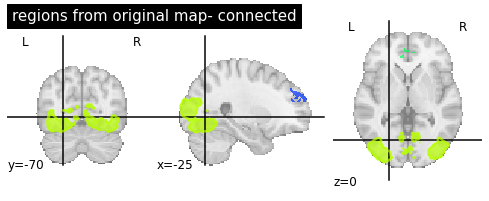

In [19]:
regions_ttest_thresh, index = connected_regions(ttest_zmap_thresh,
                                             min_region_size=800,smoothing_fwhm=None,extract_type='connected_components')
# min_region_size is in mm^3
print(index)
title = ("regions from original map- connected")
plotting.plot_prob_atlas(regions_ttest_thresh, view_type='filled_contours', display_mode='ortho',cut_coords=(-25,-70,0), title=title)
plotting.show()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


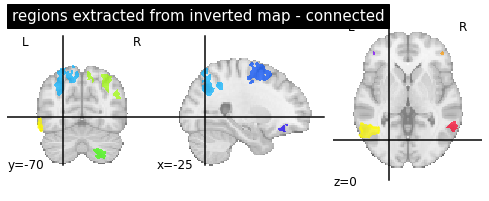

In [22]:
# Invert the ttest - the cluster extraction function works for positive values
inv_data = -1 * ttest_zmap_thresh.get_fdata()
inv_map = image.new_img_like(ttest_zmap_thresh, inv_data)
regions_ttest_inv, index = connected_regions(inv_map,
                                              ,smoothing_fwhm=None,extract_type='connected_components')
# extract_type='local_regions'
print(index)
title = ("regions extracted from inverted map - connected")
#plotting.plot_prob_atlas(regions_value_img, view_type='contours', display_mode='ortho',cut_coords=(-25,-70,0), title=title)
plotting.plot_prob_atlas(regions_ttest_inv, view_type='filled_contours', display_mode='ortho',cut_coords=(-25,-70,0), title=title)
plotting.show()

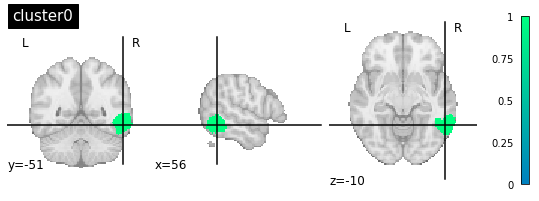

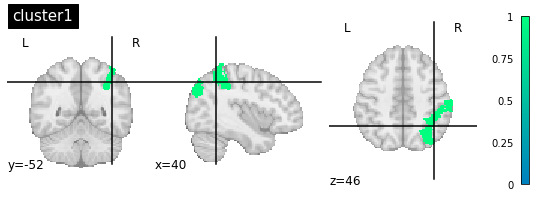

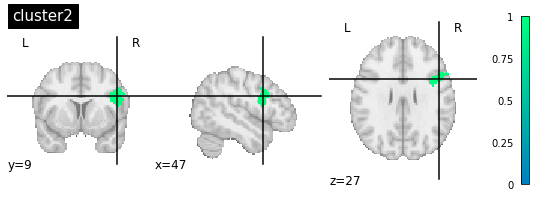

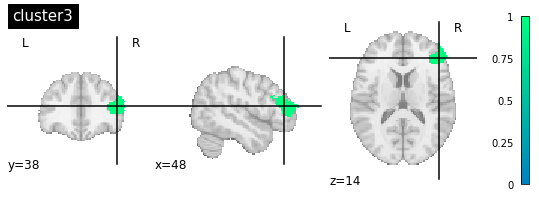

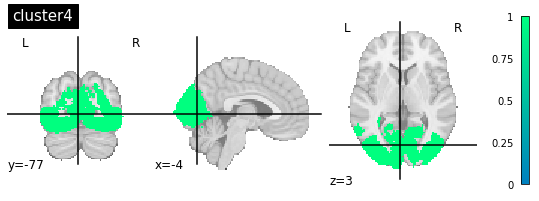

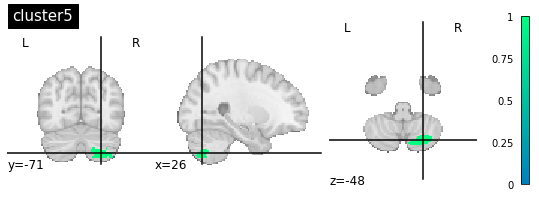

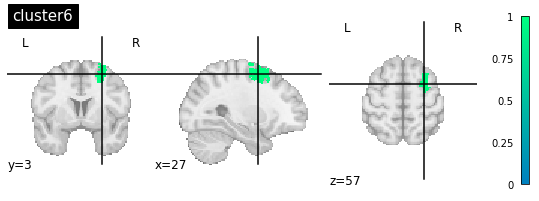

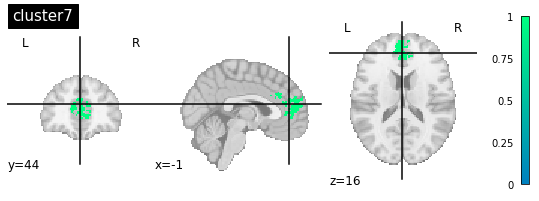

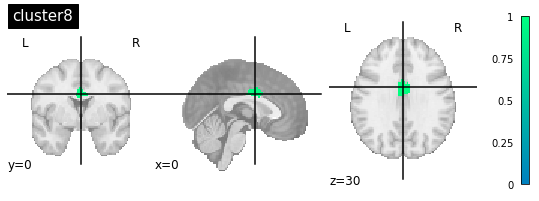

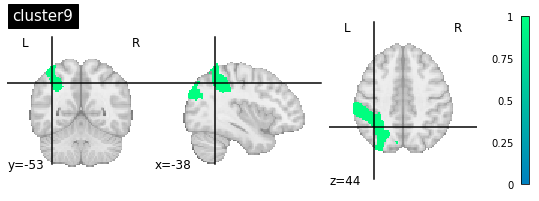

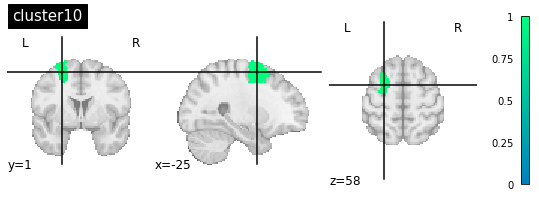

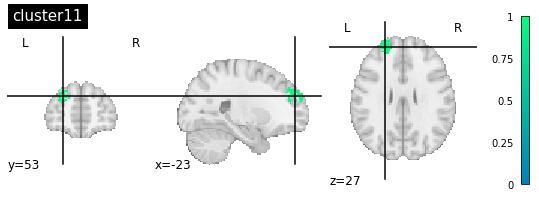

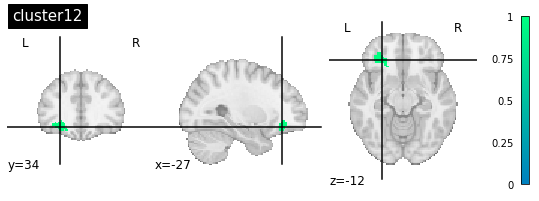

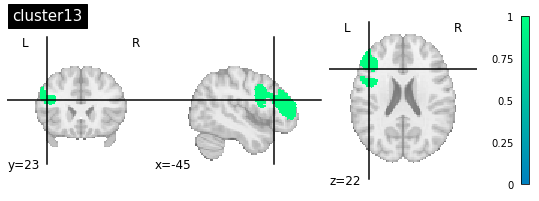

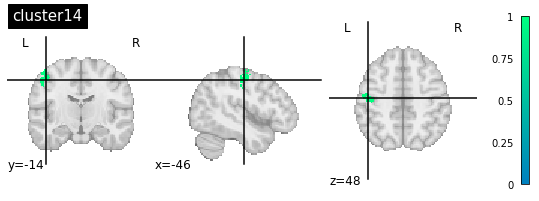

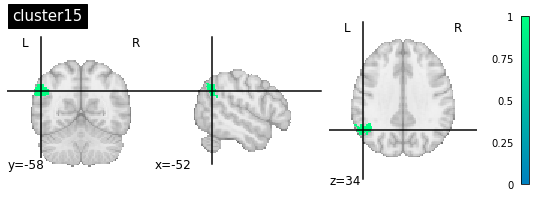

In [21]:
# separate the 4d map into separate images of one cluster each, binarize and save as nifti
all_clusters = image.copy_img(regions_ttest_thresh) # making a copy so it's easier to run on different maps
for clust_id in range(all_clusters.shape[3]):
    orig_cur_cluster = image.index_img(all_clusters, clust_id)
    orig_cluster_data = orig_cur_cluster.get_fdata()
    cluster_data = np.copy(orig_cluster_data)
    cluster_data[cluster_data != 0] = 1
    cur_cluster = image.new_img_like(orig_cur_cluster,cluster_data)
    cluster_filename = datadir + 'Clusters/Cluster_ttest_' + task + '_' + 'VWFA1-VWFA2' + 'N'+ str(len(subs))+'thresh_' + str(thresh) + 'clust_' + str(clust_thresh) + 'id' + str(clust_id) + '.nii.gz'
    cur_cluster.to_filename(cluster_filename)
    display = plotting.plot_stat_map(cur_cluster, title='cluster' + str(clust_id),cmap='winter')

In [140]:
# Save on the surface - this can be opened in Freeview
ttest_zmap_surf = surface.vol_to_surf(img=ttest_zmap,surf_mesh=fsaverage['white_left'],radius = 3)
tmap_fileName = datadir + 'ttest_' + task + '_' + 'VWFA1-VWFA2' + '_lh.curv'
nib.freesurfer.io.write_morph_data(tmap_fileName,ttest_zmap_surf)

In [46]:
# This saves a 4D nifti file - CANNOT be opened as an overlay in MRICroGL
regions_value_img.to_filename(datadir + 'ttest_' + task + '_' + 'VWFA1-VWFA2' + 'min800.nii.gz')

In [70]:
# save the map as a volume that can be opened as an overlay in MRICroGL
ttest_zmap.to_filename(datadir + 'ttest_' + task + '_' + 'VWFA1-VWFA2' + 'zMap.nii.gz')
# this can be thresholded in MRIcroGL itself

(array([  0.,   0.,   0.,   0.,   0., 240.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

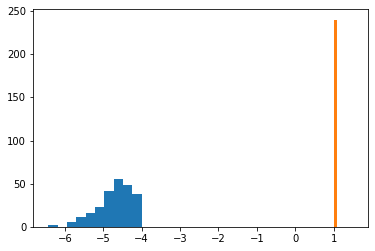

In [33]:
# just to visualize values in cluster before and after binarizing, to make sure it works as expected
clust_id=3
cur_cluster = image.index_img(regions_ttest_thresh, clust_id)
orig_cluster_data = cur_cluster.get_fdata()
cluster_data = np.copy(orig_cluster_data)
cluster_data[cluster_data != 0] = 1
new_cluster = image.new_img_like(cur_cluster,cluster_data)

plt.hist(orig_cluster_data.flatten()[orig_cluster_data.flatten()!=0])
plt.hist(cluster_data.flatten()[cluster_data.flatten()!=0])

In [21]:
# Load cluster masks and use to extract values from group data

# I loaded all clusters as overlay and MRICroGL on top of AAL atlas labels. 
# I then manually renamed the filenames so we don't have to keep both cluster name and id - 
# maybe a better way would be to create a dictionary where we can edit which cluster ID points to which ROI 
# without renaming the files
my_clusters = ['LeftIFGop','LeftIFGtri','LeftIPS','LeftMFG','RightIFGtri','RightIPS','RightOTS']

# test first for single cluster
#my_clusters = ['LeftIFGop']

roi_df = pd.DataFrame()
roi_df['participant_id'] = subs
for seed_id in range(len(roi_names)):
    for clust_id in range(len(my_clusters)):
        cluster_name = my_clusters[clust_id]
        cluster_filename = glob.glob(datadir + 'Clusters/' + '*' + cluster_name + '.nii.gz' )[0]
        print('Loading: ' + cluster_filename)
        cur_cluster_img = image.load_img(cluster_filename)
        # Display to make sure we are loading the right cluster
        display = plotting.plot_stat_map(cur_cluster_img, title=cluster_name,cmap='winter')
        #initialize vector for mean correlation value per subject
        mean_z_subs = np.empty(len(subs),'float32')
        for sub_id in range(len(subs)):
            cur_sub_filename = datadir + subs[sub_id] + '_task-' + task + '_' + roi_names[seed_id] + '_zMap.nii.gz'
            cur_data_img = image.load_img(cur_sub_filename)
      #      masked_data = masking.apply_mask(cur_data_img,cur_cluster_img)
            # The next lines of code are wrong - they average across all the image, not only in the masked region
            # which means they take into account all the zero voxels outside of the cluster of interest
            cur_cluster_data = cur_cluster_img.get_fdata()
            cur_data = cur_data_img.get_fdata().squeeze()
#           masked_data = cur_data * cur_cluster_data
            masked_data = cur_data[cur_cluster_data !=0]
            mean_z = np.nanmean(masked_data)
            mean_z_subs[sub_id] = mean_z
        
        roi_df[roi_names[seed_id]+ '_' +cluster_name] = mean_z_subs



IndexError: list index out of range

(array([ 12.,  33.,  91., 163., 197., 112.,  40.,   6.,   6.,   4.]),
 array([-0.21716765, -0.12985139, -0.04253513,  0.04478113,  0.13209739,
         0.21941365,  0.30672991,  0.39404617,  0.48136243,  0.56867869,
         0.65599495]),
 <BarContainer object of 10 artists>)

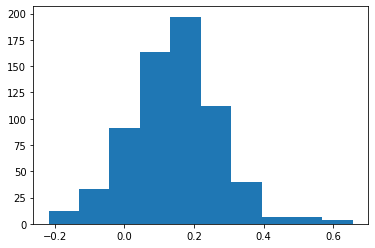

In [20]:
plt.hist(masked_data)

In [21]:
roi_df

,participant_id,VWFA1_LeftIFGop,VWFA1_LeftIFGtri,VWFA1_LeftIPS,VWFA1_LeftMFG,VWFA1_RightIFGtri,VWFA1_RightIPS,VWFA1_RightOTS,VWFA2_LeftIFGop,VWFA2_LeftIFGtri,VWFA2_LeftIPS,VWFA2_LeftMFG,VWFA2_RightIFGtri,VWFA2_RightIPS,VWFA2_RightOTS
0,sub-NDARAA948VFH,0.042012,-0.106245,0.011937,0.054939,-0.061359,0.129455,0.111668,0.022592,-0.053010,0.082823,0.022658,-0.009045,0.144164,0.208450
1,sub-NDARAC350BZ0,0.062685,-0.015448,0.101715,-0.048085,0.110812,0.046954,0.017339,0.097653,0.034234,0.135840,0.007823,0.198450,0.136340,0.096859
2,sub-NDARBF851NH6,0.203486,0.092793,0.145663,0.039779,0.184904,0.320831,0.250461,0.325658,0.145792,0.245917,0.083644,0.244008,0.473024,0.304542
3,sub-NDARBJ159HXB,0.037419,0.039697,0.099016,-0.021457,0.127263,0.227703,0.117297,0.199342,0.185292,0.215421,0.106899,0.210492,0.167332,0.301738
4,sub-NDARBR740NKV,-0.031061,-0.027347,-0.045558,-0.008695,-0.001018,0.195482,0.139111,0.161889,0.169686,0.069729,0.146179,0.164707,0.317200,0.258191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,sub-NDARZF170TZ0,0.041795,0.007621,0.058702,0.091437,0.009548,0.020659,-0.027778,0.219302,0.104370,0.212730,0.175402,0.083808,0.143436,0.149557
86,sub-NDARZM903TNL,-0.033439,-0.021418,0.056085,-0.099428,0.074118,0.064688,0.097674,-0.002847,-0.067238,0.089218,-0.065918,0.065937,0.130655,0.206348
87,sub-NDARZT940RZG,0.237031,0.085651,0.238577,0.135524,0.293590,0.303569,0.282315,0.269430,0.129497,0.232246,0.162409,0.279483,0.265327,0.252711
88,sub-NDARZW873DN3,0.042782,0.037062,0.064852,0.020232,0.092289,0.121430,0.103005,0.238559,0.142217,0.251984,0.137214,0.237492,0.157805,0.268832


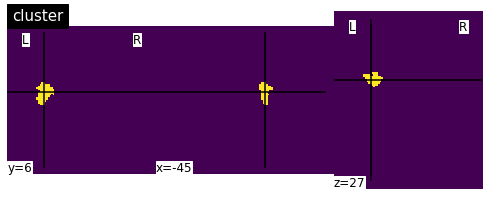

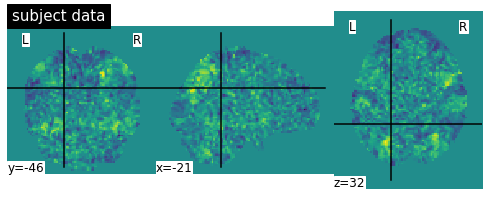

In [153]:
# Use this to test the masking process is working as expected
display = plotting.plot_img(cur_cluster_img,title='cluster')
display = plotting.plot_img(cur_data_img, title= 'subject data')
#masked_img = image.new_img_like(cur_cluster_img, masked_data) # put into nii format so we can plot
#display = plotting.plot_img(masked_img, title= 'masked data')

<AxesSubplot:>

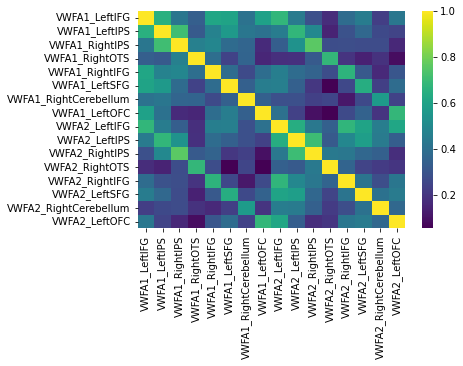

In [24]:
# plot intercorrelations between connectivity values
corrmat = roi_df_conn.corr()
#corrmat.style.background_gradient(cmap='coolwarm') # This is another nice way to plot the correlation matrix
#but the seaborn way is prettier
sns.heatmap(corrmat,cmap='viridis')

In [61]:
# read DF from CONN with values I saved
conn_per_file = '/oak/stanford/groups/jyeatman/MayasProjects/HBN_FC/CPAC_Preprocessed/Analyses/meanBetas_seed165_conn_HBN_rest_90subs.csv'
conn_per_data = pd.read_csv(conn_per_file,header=None)
conn_per_data.columns = ["VWFA1_LeftIPS","VWFA1_LeftIFG","VWFA1_RightIPS","VWFA1_RightOTS","VWFA1_RightIFG","VWFA1_LeftSFG","VWFA1_RightCerebellum","VWFA1_LeftOFC"]


conn_lex_file = '/oak/stanford/groups/jyeatman/MayasProjects/HBN_FC/CPAC_Preprocessed/Analyses/meanBetas_seed166_conn_HBN_rest_90subs.csv'
conn_lex_data = pd.read_csv(conn_lex_file,header=None)
conn_lex_data.columns = ["VWFA2_LeftIPS","VWFA2_LeftIFG","VWFA2_RightIPS","VWFA2_RightOTS","VWFA2_RightIFG","VWFA2_LeftSFG","VWFA2_RightCerebellum","VWFA2_LeftOFC"]

conn_data = pd.concat([conn_per_data,conn_lex_data],axis=1)

In [62]:
conn_data

,VWFA1_LeftIPS,VWFA1_LeftIFG,VWFA1_RightIPS,VWFA1_RightOTS,VWFA1_RightIFG,VWFA1_LeftSFG,VWFA1_RightCerebellum,VWFA1_LeftOFC,VWFA2_LeftIPS,VWFA2_LeftIFG,VWFA2_RightIPS,VWFA2_RightOTS,VWFA2_RightIFG,VWFA2_LeftSFG,VWFA2_RightCerebellum,VWFA2_LeftOFC
0,-0.009340,0.048308,0.005907,0.039655,0.013425,0.033790,0.049687,0.139930,0.102650,0.091064,0.094885,0.148220,0.055723,0.036219,0.123120,0.122110
1,0.047727,0.001412,0.042302,-0.109970,0.054986,-0.076611,-0.009991,-0.104420,0.081687,0.064157,0.102840,-0.026551,0.143680,0.008598,0.055512,-0.015092
2,0.121690,0.088163,0.171310,0.169950,0.066836,0.068196,0.105420,0.028249,0.201600,0.161510,0.296340,0.223160,0.157560,0.080653,0.197150,0.175480
3,0.068703,-0.042080,0.076657,0.071955,0.005499,-0.067392,0.036411,-0.011042,0.125760,0.134590,0.073699,0.253820,0.122580,0.086882,0.063324,0.192980
4,-0.030514,-0.061006,-0.034244,0.137480,-0.019831,0.007790,0.005214,0.020639,0.054858,0.146290,0.022759,0.236660,0.111890,0.177440,0.096506,0.184730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0.061816,-0.003830,0.047465,0.112190,0.086507,-0.098422,0.110740,0.023366,0.102170,0.028517,0.075902,0.205660,0.115890,-0.077086,0.158360,0.040570
87,0.124270,0.093976,0.047557,0.166010,0.123820,0.051566,0.023014,0.080705,0.143980,0.132040,0.077746,0.137980,0.156120,0.092032,0.056658,0.173250
88,0.038348,0.004504,0.052804,0.031965,0.017465,-0.006554,-0.019117,0.070221,0.128950,0.087220,0.115410,0.082338,0.103110,0.091922,0.081603,0.072557
89,-0.042513,-0.042317,-0.004735,-0.003109,-0.002260,-0.075559,-0.026371,-0.027823,0.148890,0.121300,0.135820,0.205580,0.145340,-0.033480,0.037798,0.033415


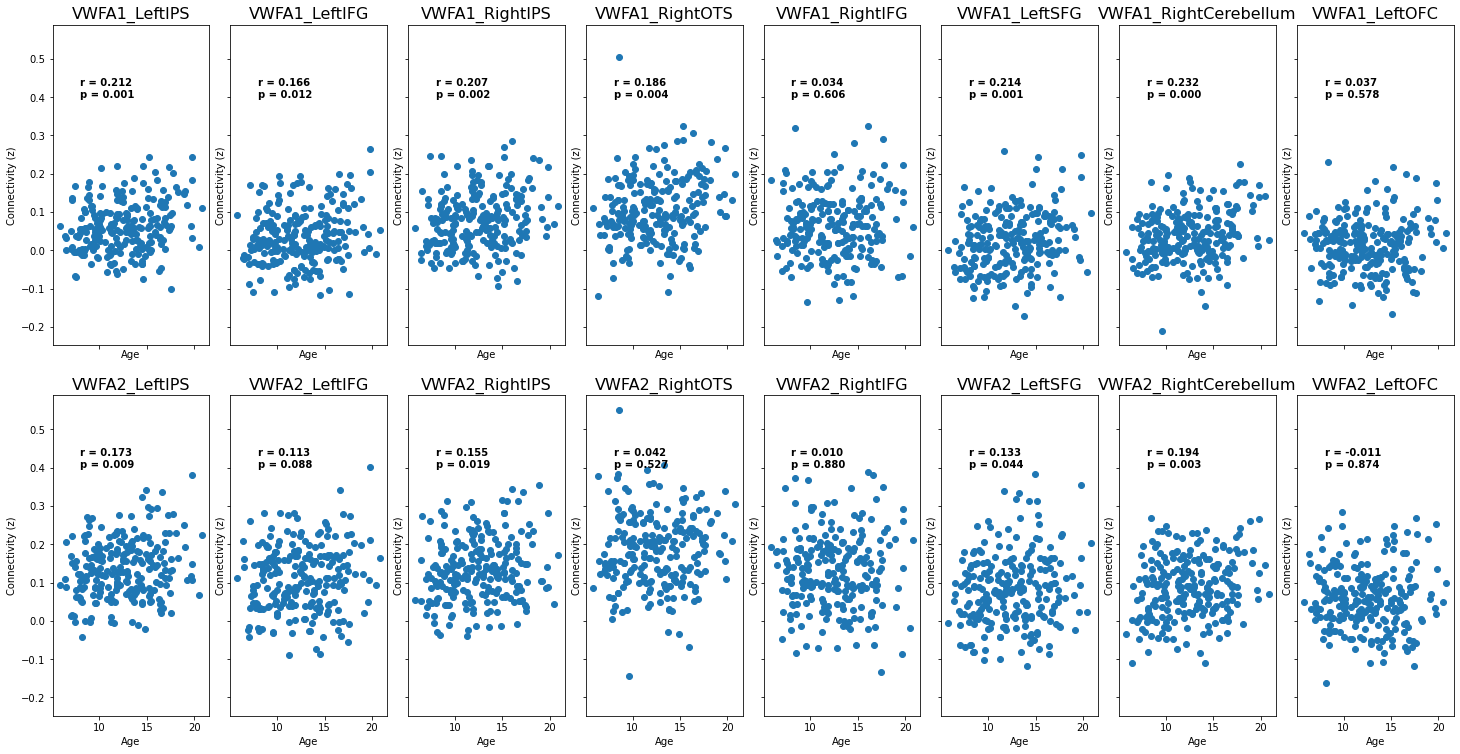

In [26]:
# plot reading against correlation values from significant clusters
myVar = 'Age' # options are WIAT_Word_Stnd, WIAT_Word_Raw, Age
myData = sub_list[myVar]

my_df = roi_df_conn # change here which df to use- roi_df/roi_df_conn
# roi_df - current analysis; roi_df_conn - testing clusters saved with CONN

# join with reading scores so we can filter both columns together
my_df[myVar] = sub_list[myVar]

conn_clusters = ['LeftIPS','LeftIFG','RightIPS','RightOTS','RightIFG','LeftSFG','RightCerebellum','LeftOFC']
my_clusters = ['LeftIFGop','LeftIFGtri','LeftIPS','LeftMFG','RightIFGtri','RightIPS','RightOTS']
my_clusters = conn_clusters

# Filter outliers? 
my_df = my_df[my_df[myVar] > (np.nanmean(my_df[myVar]) - 2.5 * np.nanstd(my_df[myVar]))]
#filterData = myData[myData > (np.nanmean(myData) - 2.5 * np.nanstd(myData))]

scat_fig, scat_axes = plt.subplots(len(roi_names),len(my_clusters),figsize=(20,10),sharey=True,sharex=True)
scat_fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=4.0)

for roi_i in range(len(roi_names)):
    for cluster_i in range(len(my_clusters)):
        cluster_name = my_clusters[cluster_i]
        cur_col = [col for col in my_df.columns if cluster_name in col and roi_names[roi_i] in col]
        scat_axes[roi_i,cluster_i].scatter(my_df[myVar],my_df.loc[:,cur_col])
        scat_axes[roi_i,cluster_i].set_xlabel(myVar)#,fontsize=14)
        scat_axes[roi_i,cluster_i].set_ylabel('Connectivity (z)')#,fontsize=14)
        cor_val, p_val = stats.pearsonr(my_df[myVar],my_df.loc[:,cur_col])
       # plt.annotate("r = {:.3f}".format(cor_val), (0, 1))
        if myVar == 'Age':
            xpos = 8
        else:
            xpos = 50
        scat_axes[roi_i,cluster_i].text(xpos, 0.4, "r = {:.3f}\np = {:.3f}".format(cor_val[0],p_val), horizontalalignment='left', size='medium', weight='semibold')
        scat_axes[roi_i,cluster_i].set_title(cur_col[0],fontsize=16)

In [53]:
sub_list

,Unnamed: 0,X.1,X,X.x,participant_id,preproc,existsRun1,existsRun2,existsMovieDM,existsMovieTP,...,rec_id,run_id,raw_neighbor_corr_pass,t1_neighbor_corr_pass,mean_fd_pass,t1_dice_distance_pass,raw_num_bad_slices_pass,qc_pass,WIAT_Word_Raw.y,WIAT_Word_Stnd.y
0,1,3,3,3,sub-NDARAA948VFH,1,1,1,1,1,...,NaN,NaN,True,True,True,True,True,1.0,26.0,96.0
1,2,4,4,4,sub-NDARAB458VK9,1,1,1,0,0,...,NaN,NaN,True,True,True,True,True,1.0,62.0,110.0
2,3,6,6,6,sub-NDARAC349YUC,1,1,1,0,0,...,NaN,NaN,True,True,True,True,True,1.0,49.0,105.0
3,4,7,7,7,sub-NDARAC350BZ0,1,1,1,1,1,...,NaN,NaN,True,True,True,True,True,1.0,67.0,117.0
4,5,23,23,23,sub-NDARAG340ERT,1,1,1,1,1,...,NaN,NaN,True,True,True,True,True,1.0,52.0,104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,227,1536,1536,1536,sub-NDARZL113CU0,1,1,1,0,0,...,NaN,NaN,True,True,True,True,True,1.0,29.0,113.0
227,228,1540,1540,1540,sub-NDARZM903TNL,1,1,1,1,1,...,NaN,NaN,True,True,True,True,True,1.0,55.0,116.0
228,229,1547,1547,1547,sub-NDARZT940RZG,1,1,1,1,1,...,NaN,NaN,True,True,True,True,True,1.0,69.0,116.0
229,230,1552,1552,1552,sub-NDARZW873DN3,1,1,1,1,1,...,NaN,NaN,True,True,True,True,True,1.0,51.0,93.0


(<Figure size 288x324 with 5 Axes>,
 [<Axes3DSubplot:>,
  <Axes3DSubplot:>,
  <Axes3DSubplot:>,
  <Axes3DSubplot:>,
  <AxesSubplot:>])

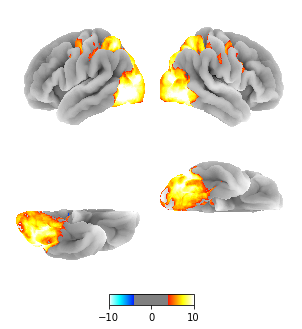

In [20]:
# Another plotting function
#plotting.plot_img_on_surf(stat_map=roi1_thresh_map, surf_mesh='fsaverage',vmax=10,threshold=4,
#                            views=['lateral','ventral'])
#plotting.plot_img_on_surf(stat_map=roi2_thresh_map, surf_mesh='fsaverage',vmax=10,threshold=4,
#                            views=['lateral','ventral'])

### Import clusters saved with CONN

Loading: /scratch/groups/jyeatman/HBN_FC/volume/statMaps/Clusters/CONN/Cluster-3_LeftIFG.nii
Loading: /scratch/groups/jyeatman/HBN_FC/volume/statMaps/Clusters/CONN/Cluster-2_LeftIPS.nii
Loading: /scratch/groups/jyeatman/HBN_FC/volume/statMaps/Clusters/CONN/Cluster-5_RightIPS.nii
Loading: /scratch/groups/jyeatman/HBN_FC/volume/statMaps/Clusters/CONN/Cluster-6_RightOTS.nii
Loading: /scratch/groups/jyeatman/HBN_FC/volume/statMaps/Clusters/CONN/Cluster-7_RightIFG.nii
Loading: /scratch/groups/jyeatman/HBN_FC/volume/statMaps/Clusters/CONN/Cluster-8_LeftSFG.nii
Loading: /scratch/groups/jyeatman/HBN_FC/volume/statMaps/Clusters/CONN/Cluster-9_RightCerebellum.nii
Loading: /scratch/groups/jyeatman/HBN_FC/volume/statMaps/Clusters/CONN/Cluster-10_LeftOFC.nii
Loading: /scratch/groups/jyeatman/HBN_FC/volume/statMaps/Clusters/CONN/Cluster-3_LeftIFG.nii
Loading: /scratch/groups/jyeatman/HBN_FC/volume/statMaps/Clusters/CONN/Cluster-2_LeftIPS.nii
Loading: /scratch/groups/jyeatman/HBN_FC/volume/statMaps/C

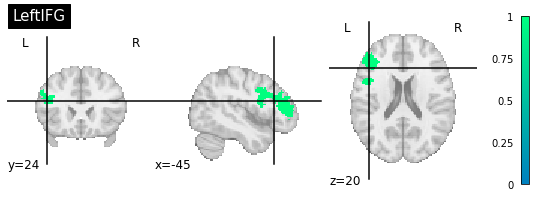

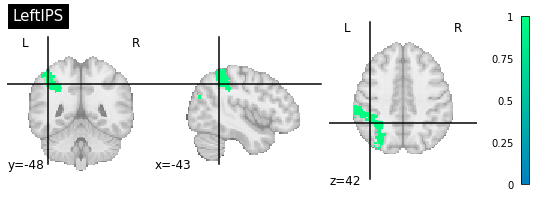

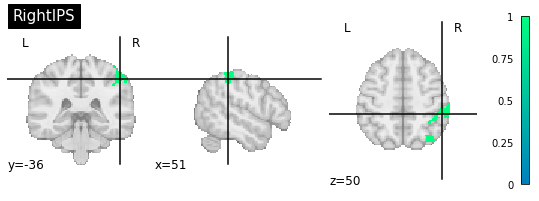

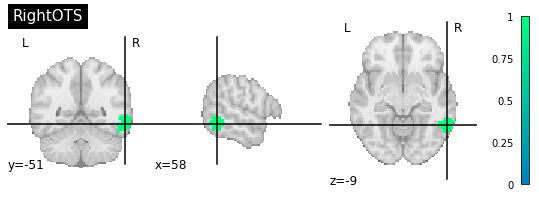

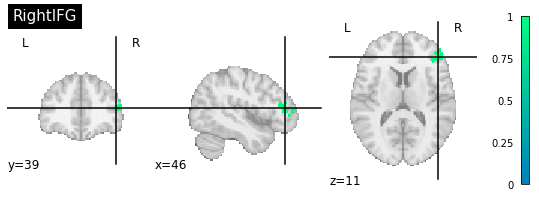

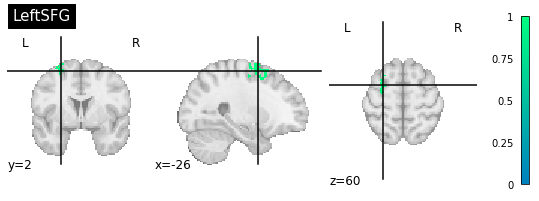

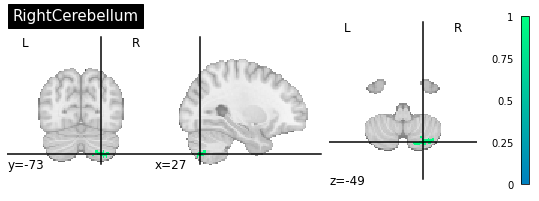

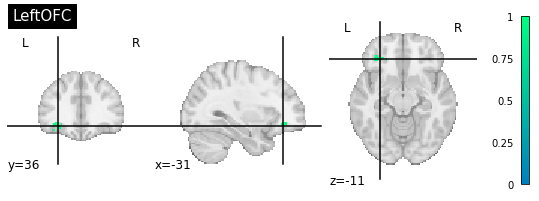

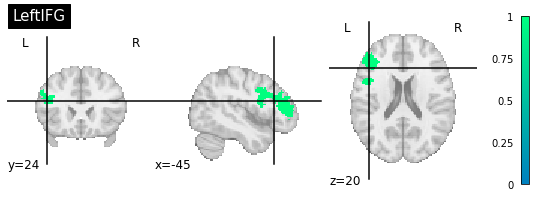

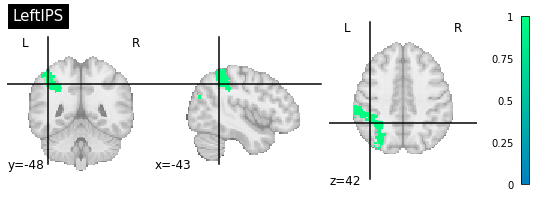

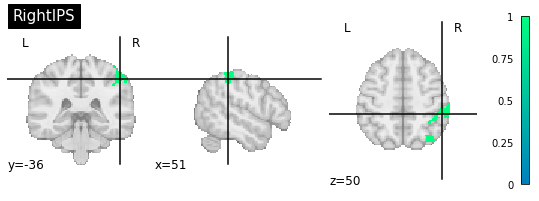

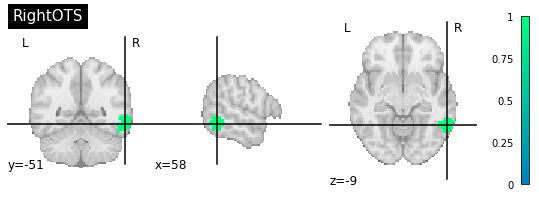

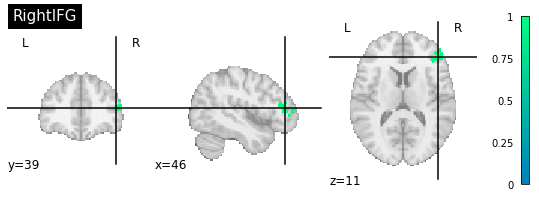

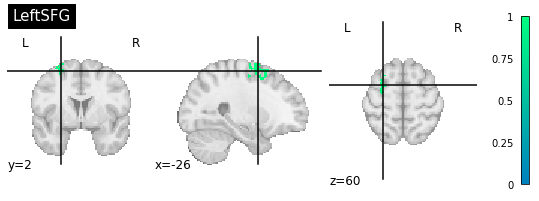

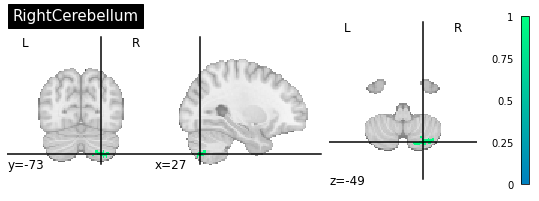

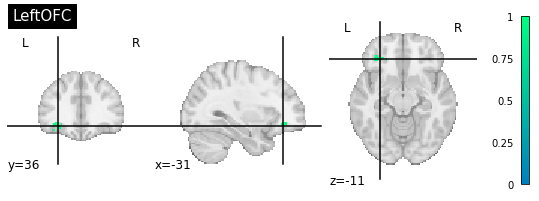

In [22]:
# Load cluster masks FRON CONN and use to extract values from group data

# I copied the files from the CONN folders on oak:
# /oak/MayasProjects/HBN_FC/CPAC_Preprocessed/conn_HBN_rest_90subs/results/secondlevel/SBC_01/AllSubjects/rest/VWFA.VWFA_PER_(1).VWFA.VWFA_LEX_(-1)/Cluster-1.nii
# Then renamed according to the table in my drive:
# https://docs.google.com/spreadsheets/d/1tjH0_kEXodzS1Qw1125p7zMS7sv6rs4379RupGf7PK0/
my_clusters = ['LeftIFG','LeftIPS','RightIPS','RightOTS','RightIFG','LeftSFG','RightCerebellum','LeftOFC']
#my_clusters = ['RightIPS']
# test first for single cluster
#my_clusters = [12]
#cluster_names = ['LeftIFG']

roi_df_conn = pd.DataFrame()
for seed_id in range(len(roi_names)):
    for clust_id in range(len(my_clusters)):
        cluster_name = my_clusters[clust_id]
        cluster_filename = glob.glob(datadir + 'Clusters/CONN/' + '*' + cluster_name + '.nii' )[0]
        print('Loading: ' + cluster_filename)
        cur_cluster_img = image.load_img(cluster_filename)
        # Display to make sure we are loading the right cluster
        display = plotting.plot_stat_map(cur_cluster_img, title=cluster_name,cmap='winter')
        mean_z_subs = np.empty(len(subs),'float32')
        for sub_id in range(len(subs)):
            cur_sub_filename = datadir + subs[sub_id] + '_task-' + task + '_' + roi_names[seed_id] + '_zMap.nii.gz'
            cur_data_img = image.load_img(cur_sub_filename)
#            masked_data = masking.apply_mask(cur_data,cur_cluster)
            cur_cluster_data = cur_cluster_img.get_fdata()
            cur_data = cur_data_img.get_fdata().squeeze()
            #masked_data = cur_data * cur_cluster_data
            masked_data = cur_data[cur_cluster_data !=0]
            mean_z = np.nanmean(masked_data)
            mean_z_subs[sub_id] = mean_z
        
        roi_df_conn[roi_names[seed_id]+ '_' +cluster_name] = mean_z_subs 


In [23]:
roi_df_conn

,VWFA1_LeftIFG,VWFA1_LeftIPS,VWFA1_RightIPS,VWFA1_RightOTS,VWFA1_RightIFG,VWFA1_LeftSFG,VWFA1_RightCerebellum,VWFA1_LeftOFC,VWFA2_LeftIFG,VWFA2_LeftIPS,VWFA2_RightIPS,VWFA2_RightOTS,VWFA2_RightIFG,VWFA2_LeftSFG,VWFA2_RightCerebellum,VWFA2_LeftOFC
0,-0.035972,-0.008035,-0.017119,0.059804,-0.069615,0.061666,0.034354,0.056881,-0.019664,0.060996,0.047860,0.141071,-0.023051,0.047144,0.096899,0.051975
1,0.110536,0.058143,0.058057,0.075217,-0.069435,0.004048,0.062473,-0.008153,0.141851,0.070104,0.071329,0.073648,-0.071623,0.007885,0.080268,0.002063
2,0.124753,0.025569,0.009857,0.112576,0.107448,-0.000201,-0.031639,0.019720,0.159940,0.086676,0.112282,0.202039,0.186359,0.030833,-0.046417,0.031287
3,-0.003191,0.059839,0.064557,-0.032003,0.055242,-0.073561,0.017139,-0.092662,0.039034,0.102434,0.125848,0.050551,0.144134,-0.019144,0.070772,-0.052597
4,0.067585,0.100644,0.120277,0.152807,0.128492,0.097906,0.113556,-0.046556,0.159260,0.190498,0.199257,0.282122,0.193751,0.166600,0.163425,0.035585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,-0.016801,0.003108,0.024604,0.041103,-0.054578,-0.005925,0.082478,0.043191,-0.024558,0.011614,0.014381,0.128354,-0.048012,0.025375,0.054074,0.046702
227,-0.024263,0.056940,0.041516,0.070477,0.061268,-0.068627,0.003034,0.052172,-0.027930,0.086513,0.076636,0.174588,0.048002,-0.042959,0.060505,0.015223
228,0.094833,0.219909,0.197096,0.285557,0.279807,0.096085,0.045494,0.043861,0.149626,0.223446,0.174877,0.260522,0.276205,0.130028,0.077508,0.082680
229,0.015514,0.046200,0.084842,0.094652,0.089750,0.019726,0.011770,0.124772,0.113124,0.194436,0.247830,0.210388,0.206685,0.129673,0.160379,0.101701


ValueError: Length of values (90) does not match length of index (1)

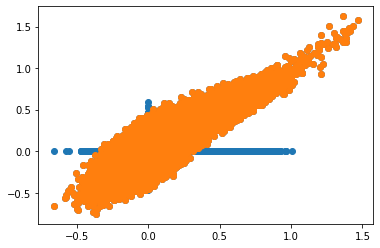

In [24]:
# Test values from CONN
corr_df = pd.DataFrame()
conn_maps = sorted(glob.glob('/oak/stanford/groups/jyeatman/MayasProjects/HBN_FC/CPAC_Preprocessed/conn_HBN_rest_90subs/results/firstlevel/SBC_01/BETA_Subject*' + 'Condition001_Source166.nii'),key=os.path.basename)
rval_group = np.empty(len(conn_maps))
pval_group = np.empty(len(conn_maps))
sub_files = []

#for sub_id in range(len(subs)):
    
for sub_id in range(1):
    #'BETA_Subject%s_Condition001_Source166.nii
    conn_map = image.load_img(conn_maps[sub_id])
    conn_vals = conn_map.get_fdata().flatten()
    #conn_maps = glob.glob('/oak/stanford/groups/jyeatman/MayasProjects/HBN_FC/CPAC_Preprocessed/conn_HBN_rest_90subs/results/firstlevel/SBC_01/BETA_Subject*' + 'Condition001_Source166.nii')
    nilearn_map = image.load_img(files_roi2[sub_id])
   # print(files_roi2[sub_id])
    nilearn_vals = nilearn_map.get_fdata().flatten()
    plt.scatter(nilearn_vals,conn_vals)
    myfilter = np.logical_and(nilearn_vals!=0, conn_vals!=0) 
    nilearn_vals = nilearn_vals[myfilter]
    conn_vals = conn_vals[myfilter]
    plt.scatter(nilearn_vals,conn_vals)
    rval,pval = stats.pearsonr(nilearn_vals,conn_vals)
    #print('subject ' + str(sub_id) + 'r: '+ str(rval) + ',p: ' + str(pval))
    rval_group[sub_id] = rval
    pval_group[sub_id] = pval
    sub_files.append(os.path.basename(files_roi2[sub_id]))
corr_df['sub'] = sub_files
corr_df['rval'] = rval_group
corr_df['pval'] = pval_group
    

0.7842095843882608 0.0


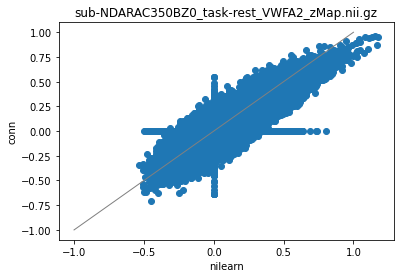

In [123]:
plt.scatter(nilearn_vals,conn_vals)
rval,pval = stats.pearsonr(nilearn_vals,conn_vals)
plt.xlabel('nilearn') 
plt.ylabel('conn')
plt.plot([-1,1],[-1,1],linewidth=1,color='grey') # identity line
plt.title(os.path.basename(files_roi2[sub_id]))
print(rval,pval)

0.7285063867671878 0.0


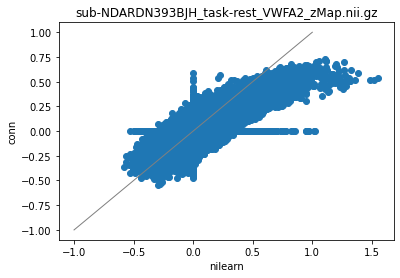

In [127]:
plt.scatter(nilearn_vals,conn_vals)
rval,pval = stats.pearsonr(nilearn_vals,conn_vals)
plt.xlabel('nilearn') 
plt.ylabel('conn')
plt.plot([-1,1],[-1,1],linewidth=1,color='grey') # identity line
plt.title(os.path.basename(files_roi2[sub_id]))
print(rval,pval)

0.7818247247650548 0.0


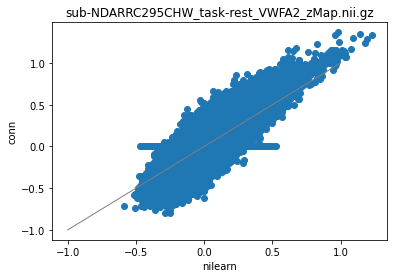

In [129]:
plt.scatter(nilearn_vals,conn_vals)
rval,pval = stats.pearsonr(nilearn_vals,conn_vals)
plt.xlabel('nilearn') 
plt.ylabel('conn')
plt.plot([-1,1],[-1,1],linewidth=1,color='grey') # identity line
plt.title(os.path.basename(files_roi2[sub_id]))
print(rval,pval)

0.864367782055641 0.0


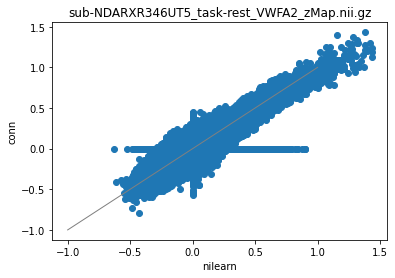

In [131]:
plt.scatter(nilearn_vals,conn_vals)
rval,pval = stats.pearsonr(nilearn_vals,conn_vals)
plt.xlabel('nilearn') 
plt.ylabel('conn')
plt.plot([-1,1],[-1,1],linewidth=1,color='grey') # identity line
plt.title(os.path.basename(files_roi2[sub_id]))
print(rval,pval)

0.38271896674384975 0.0


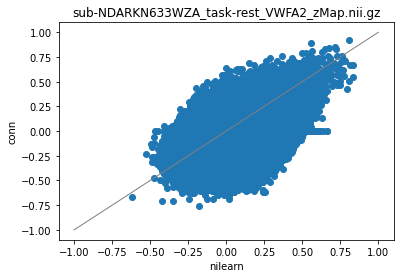

In [141]:
plt.scatter(nilearn_vals,conn_vals)
rval,pval = stats.pearsonr(nilearn_vals,conn_vals)
plt.xlabel('nilearn') 
plt.ylabel('conn')
plt.plot([-1,1],[-1,1],linewidth=1,color='grey') # identity line
plt.title(os.path.basename(files_roi2[sub_id]))
print(rval,pval)

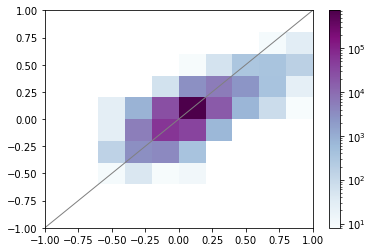

In [94]:
import matplotlib.colors as colors
plt.hist2d(nilearn_vals,conn_vals,range=[[-1,1],[-1,1]],cmap=plt.cm.BuPu, norm=colors.LogNorm())
plt.colorbar()
ax.set_xlabel('nilearn') 
ax.set_ylabel('conn')
plt.plot([-1,1],[-1,1],linewidth=1,color='grey') # identity line